In [4]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import math
import random
import numpy as np
import os
import pandas as pd
from copy import copy


In [19]:
single_item_width = 80

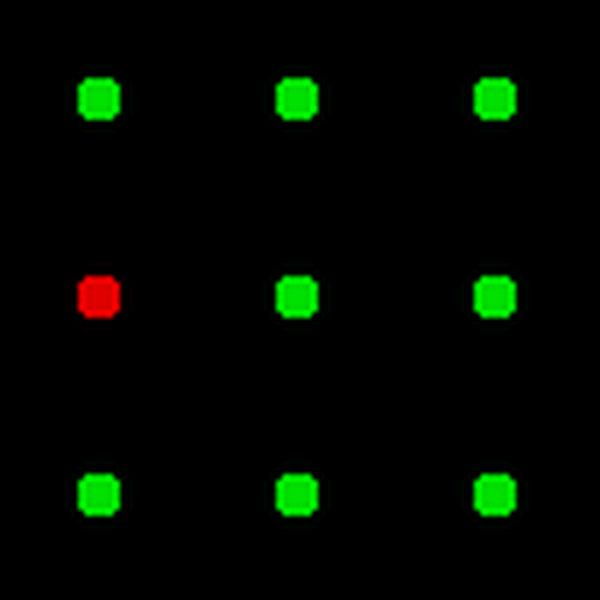

In [6]:
# my_rois = np.load('clutter_rois.npy') 
# my_rois = np.load('my_rois.npy')
# my_rois = np.load('red_popout_rois.npy') 
my_rois = np.load('red_popout_rois_1.npy')
# my_rois = np.load('grating_rois_1.npy')
# my_rois = np.load('popout_rois.npy') 
my_rois = my_rois[0,:,:]
# image = Image.new("RGB", (600, 800))
image = Image.open('/om/user/xf15/NN/project/test_popout_red_circles_on_grid/cat09image0000.png')
# image = Image.open('/om/user/xf15/NN/project/test_popout_green_circles_on_grid/cat09image0000.png')
# image = Image.open('/om/user/xf15/NN/project/test_colorful_circles_on_grid/cat09image0001.png')
# image = Image.open('/om/user/xf15/NN/project/test_colorful_circles/cat10image0000.png')
num_box = my_rois.shape[0] #300
min_rgb = 20
max_rgb = 256
# rs = np.arange(50, 256, (256-50)//(num_box/3)).astype(int)
# gs = np.arange(50, 256, (256-50)//(num_box/3)).astype(int)
# bs = np.arange(50, 256, (256-50)//(num_box/3)).astype(int)

# gs = np.repeat(0, num_box)
# bs = np.repeat(0, num_box)
small_rois = np.ndarray((1,4), dtype="float32")
for iB in range(num_box-1):
    if my_rois[iB, 3] - my_rois[iB, 1] < single_item_width and my_rois[iB, 3] - my_rois[iB, 1] < 80:
        small_rois = np.vstack((small_rois, my_rois[iB, 1:5]))
small_rois = small_rois[1:,:]        
num_small_rois = small_rois.shape[0] #56
rs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
gs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
bs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
# print(my_rois.shape)
# print(small_rois.shape)
image

In [7]:
def np_vec_no_jit_iou(boxes1, boxes2):
#     https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d
    def run(bboxes1, bboxes2):
        x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
        x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
        xA = np.maximum(x11, np.transpose(x21))
        yA = np.maximum(y11, np.transpose(y21))
        xB = np.minimum(x12, np.transpose(x22))
        yB = np.minimum(y12, np.transpose(y22))
        interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
        boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
        boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
        iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
        return iou
    a = run(boxes1, boxes2)
    return a
b = np_vec_no_jit_iou(small_rois, small_rois)
c = b.sum(axis = 0)
d = np.where(c < 2)[0] 
# d = np.where(c < np.mean(c) - 2 * np.std(c))[0] # use mean and std

# print(b.shape)
# print(c.shape)
# print(d.shape)

print(np.mean(c))
print(np.std(c))

# import matplotlib.pyplot as plt
# plt.imshow(b);
# plt.colorbar()
# plt.show()

5.0174723
0.9355564


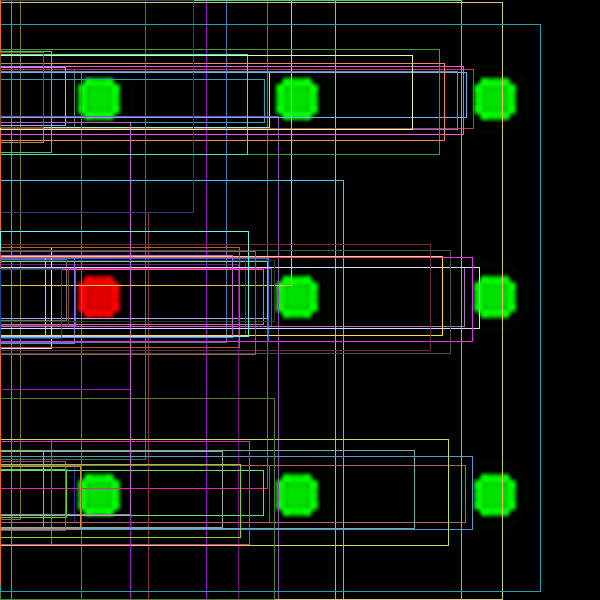

In [18]:
image1 = copy(image)
draw1 = ImageDraw.Draw(image1)
for iB in range(num_small_rois-1):
#     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
    draw1.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image1.show()
# image1.save('temp.png')
image1

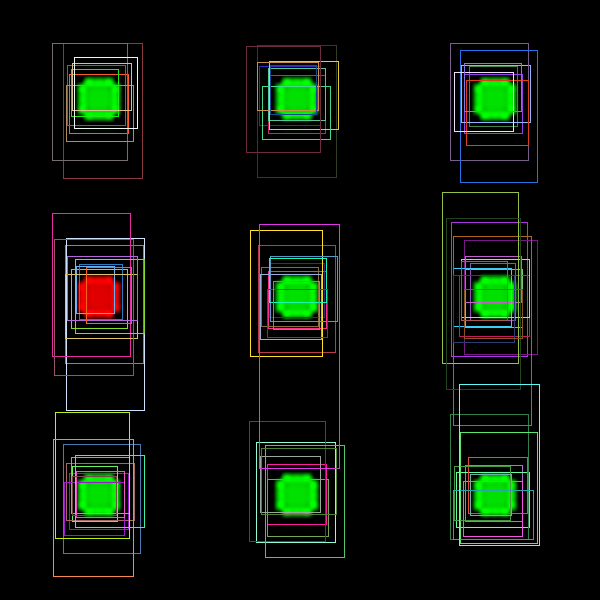

In [9]:
image2 = copy(image)
draw2 = ImageDraw.Draw(image2)
# for iB in range(num_small_rois-1):
# for iB in d:
for iB in list(set(range(num_small_rois-1)) - set(d)):
    draw2.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image2.show()
# image2.save('temp.png')
image2

In [10]:
small_rois.shape

(91, 4)

In [11]:
small_rois_centers = (small_rois[:, 0:2] + small_rois[:, 2:4])/2

In [12]:
small_rois_centers.shape

(91, 2)

In [21]:
from sklearn.cluster import MeanShift
clustering = MeanShift(bandwidth=single_item_width).fit(small_rois_centers)
num_clusters = len(set(clustering.labels_))
mean_clusterred_rois = np.zeros((num_clusters, 4), dtype = "float32")
for iC in range(num_clusters):
    mean_clusterred_rois[iC] = np.mean(small_rois[np.where(clustering.labels_ == iC)[0], :], axis=0)
mean_clusterred_rois.shape

(9, 4)

In [14]:
image3 = copy(image)
draw3 = ImageDraw.Draw(image3)
for iB in mean_clusterred_rois:
    print(iB)
    draw3.rectangle(iB, outline = (200,200,200))

[462.74542 243.80103 527.34894 357.35184]
[264.35403 260.2289  327.1236  343.6204 ]
[ 67.37832 458.52835 129.41063 531.8791 ]
[ 69.25131 254.21992 133.45862 343.90985]
[460.41718 453.98602 526.3893  530.2336 ]
[262.24258  64.32488 325.9222  133.82652]
[ 68.38352   63.981705 129.53937  134.13986 ]
[461.67545   64.702354 525.0546   139.24821 ]
[261.2027  451.2487  331.086   532.89386]


In [15]:
print(b.shape)
print(c.shape)
print(d.shape)

(91, 91)
(91,)
(1,)


In [16]:
mean_clusterred_rois = np.concatenate((np.zeros((1, num_clusters)).T, mean_clusterred_rois), axis=1)

In [17]:
mean_clusterred_rois

array([[  0.        , 462.74542236, 243.80102539, 527.34893799,
        357.35183716],
       [  0.        , 264.35403442, 260.22891235, 327.12359619,
        343.62039185],
       [  0.        ,  67.37831879, 458.52835083, 129.41062927,
        531.87908936],
       [  0.        ,  69.25131226, 254.21992493, 133.45861816,
        343.90985107],
       [  0.        , 460.41717529, 453.98602295, 526.38928223,
        530.23358154],
       [  0.        , 262.24258423,  64.32488251, 325.92221069,
        133.82652283],
       [  0.        ,  68.38352203,  63.98170471, 129.53936768,
        134.13986206],
       [  0.        , 461.67544556,  64.70235443, 525.05462646,
        139.24821472],
       [  0.        , 261.20269775, 451.24868774, 331.08599854,
        532.89385986]])